# initialisation

In [1]:
import backproject
import numpy as np
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import glob
import cv2
import torch
from sklearn.cluster import KMeans
import os

In [2]:
path_to_traj = "/home/koerner/Project_Dogu/wsnsl/Datasets/Replica/room0/traj.txt"
T_wc = np.loadtxt(path_to_traj).reshape(-1, 4, 4)
T_wc[:, 1:3] *= -1
color_paths = sorted(glob.glob("/home/koerner/Project_Dogu/wsnsl/Datasets/Replica/room0/results/frame*.jpg"))
print(color_paths)
depth_paths = sorted(glob.glob(f"/home/koerner/Project_Dogu/wsnsl/Datasets/Replica/room0/results/depth*.png"))
print(depth_paths)

['/home/koerner/Project_Dogu/wsnsl/Datasets/Replica/room0/results/frame000000.jpg', '/home/koerner/Project_Dogu/wsnsl/Datasets/Replica/room0/results/frame000001.jpg', '/home/koerner/Project_Dogu/wsnsl/Datasets/Replica/room0/results/frame000002.jpg', '/home/koerner/Project_Dogu/wsnsl/Datasets/Replica/room0/results/frame000003.jpg', '/home/koerner/Project_Dogu/wsnsl/Datasets/Replica/room0/results/frame000004.jpg', '/home/koerner/Project_Dogu/wsnsl/Datasets/Replica/room0/results/frame000005.jpg', '/home/koerner/Project_Dogu/wsnsl/Datasets/Replica/room0/results/frame000006.jpg', '/home/koerner/Project_Dogu/wsnsl/Datasets/Replica/room0/results/frame000007.jpg', '/home/koerner/Project_Dogu/wsnsl/Datasets/Replica/room0/results/frame000008.jpg', '/home/koerner/Project_Dogu/wsnsl/Datasets/Replica/room0/results/frame000009.jpg', '/home/koerner/Project_Dogu/wsnsl/Datasets/Replica/room0/results/frame000010.jpg', '/home/koerner/Project_Dogu/wsnsl/Datasets/Replica/room0/results/frame000011.jpg', '/h

In [3]:
'''
for i in range(20):
    color_path = color_paths[i*50]
    color_data = cv2.imread(color_path)
    image = cv2.cvtColor(color_data, cv2.COLOR_BGR2RGB)
    masks = mask_generator.generate(image)
    images.append(image)
    masksarr.append(masks)
del sam
'''


'\nfor i in range(20):\n    color_path = color_paths[i*50]\n    color_data = cv2.imread(color_path)\n    image = cv2.cvtColor(color_data, cv2.COLOR_BGR2RGB)\n    masks = mask_generator.generate(image)\n    images.append(image)\n    masksarr.append(masks)\ndel sam\n'

In [4]:
import vis
import matplotlib.pyplot as plt
'''
for i in range(20):
    plt.figure(figsize=(20,20))
    plt.imshow(images[i])
    vis.show_anns(masksarr[i])
    plt.axis('off')
    plt.show() 
    '''
def visualizerForAuto(image, masks):
    plt.figure(figsize=(20,20))
    plt.imshow(image)
    vis.show_anns(masks)
    plt.axis('off')
    plt.show() 
def visualizerWithPrompts(image,masks,prompts):
    plt.figure(figsize=(20,20))
    plt.imshow(image)
    vis.show_anns(masks)
    plt.scatter(prompts[0,:],prompts[1,:],c='r',s=10)
    plt.axis('off')
    plt.show()

In [5]:
images=[]
masksarr=[]

K = np.eye(3)
K[0, 0] = 600.0
K[1, 1] = 600.0
K[0, 2] = 599.5
K[1, 2] = 339.5

# Helper

In [ ]:

def readDepth(filepath):
    depth = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)
    depth_data = depth.astype(np.float32) / 6553.5
    depth_data = torch.from_numpy(depth_data)
    return depth_data


def checkIfInsideImage(backprojectedSamples, zg, Depthg, border):
    backprojectedSamples = backprojectedSamples.astype(int)
    # efficient
    # filter out samples outside of image bounds
    condition = (
        (backprojectedSamples[1, :] < 0 + border)
        | (backprojectedSamples[0, :] < 0 + border)
        | (backprojectedSamples[1, :] > 679 - border)
        | (backprojectedSamples[0, :] > 1199 - border)
    )
    filteredIndices = np.where(condition)
    filteredBackProj = backprojectedSamples[:, ~condition]

    depthg = np.array(Depthg[filteredBackProj[1, :], filteredBackProj[0, :]])
    zg = np.delete(zg, filteredIndices)
    depthCheck = depthg - zg
    # print(f'depthCkeck, smaller 0.005: {np.count_nonzero(abs(depthCheck) < 0.005)}, depthCheck, smaller 0.01: {np.count_nonzero(abs(depthCheck) < 0.01)}, smaller 0.1: {np.count_nonzero(abs(depthCheck) < 0.1)}')
    indices = np.where(abs(depthCheck) < 0.01)
    filteredBackProj = filteredBackProj[:, indices]
    return filteredBackProj

def generateIds(masks, min_area=1000):
    """sortedMasks = sorted(masks, key=(lambda x: x["area"]), reverse=True)
    ids = np.ones(
        (
            sortedMasks[0]["segmentation"].shape[0],
            sortedMasks[0]["segmentation"].shape[1],
            1,
        )
    )
    # maybe more efficient
    # first frame has 85 instances so not too bad
    for i, ann in enumerate(sortedMasks):
        m = ann["segmentation"]
        idsForEachMask = np.concatenate([[i]])
        ids[m] = idsForEachMask
    return ids.squeeze().astype(np.int32)"""
    sortedMasks = sorted(masks, key=(lambda x: x["area"]), reverse=True)
    if min_area > 0:
        sortedMasks = [mask for mask in sortedMasks if mask["area"] > min_area]
    ids = np.full(
            (sortedMasks[0]["segmentation"].shape[0],
            sortedMasks[0]["segmentation"].shape[1]),
            -100,
        )
    for i, ann in enumerate(sortedMasks):
        m = ann["segmentation"]
        ids[m] = i
    unique_ids,counts = np.unique(ids, return_counts=True)
    for i in range(len(unique_ids)):
        if counts[i] < min_area:
            ids[ids == unique_ids[i]] = -100
    return ids

def sample_from_instances_with_ids_area(ids, numberOfMasks, points_per_instance=1):
    tensors = []

    temp=np.unique(ids)[1:]
    for i,element in enumerate(list(temp.astype(int))):
        if element >=0:            
            labels = np.where(ids == element)
            indices = list(zip(labels[0], labels[1]))
            points_per_instance= np.sum(ids == element)
            points_per_instance=int(2*np.log2(points_per_instance))
            if len(indices) > points_per_instance:  # Check if there are any True pixels
                sampled_indices = np.linspace(0, len(indices)-1, points_per_instance, dtype=int)
                sampled_tensor = torch.tensor([indices[j][::-1] for j in sampled_indices]).T
                element_tensor = torch.full((sampled_tensor.shape[1],), element)
                
                element_tensor = element_tensor.unsqueeze(0)
                
                tensors.append(torch.cat((sampled_tensor, element_tensor), axis=0))

    torch_sampled_indices = torch.cat(tensors, axis=1)
    return torch_sampled_indices.to(torch.int32)

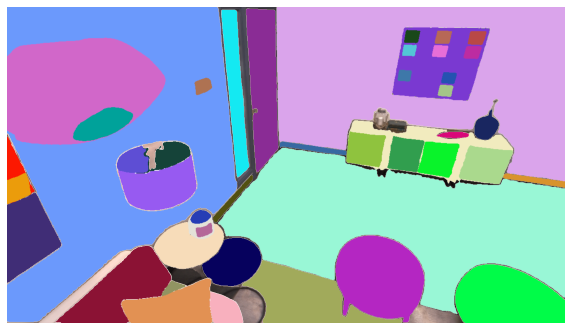

In [ ]:
sam_checkpoint = '/home/koerner/Project/nice-slam/sam/sam_vit_h_4b8939.pth'
model_type = "vit_h"


sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device="cuda")


mask_generator = SamAutomaticMaskGenerator(
    sam, points_per_side=16, pred_iou_thresh=0.9, stability_score_thresh=0.9, crop_nms_thresh=0.2,box_nms_thresh=0.4,crop_n_layers=0, crop_n_points_downscale_factor=2, min_mask_region_area=10000)
#crop_n_layers (int): If >0, mask prediction will be run again on
#crops of the image. Sets the number of layers to run, where each
 #layer has 2**i_layer number of image crops.
 #crop_nms_thresh (float): The box IoU cutoff used by non-maximal suppression to filter duplicate masks between different crops.
"""
        Using a SAM model, generates masks for the entire image.
        Generates a grid of point prompts over the image, then filters
        low quality and duplicate masks. The default settings are chosen
        for SAM with a ViT-H backbone.

        Arguments:
          model (Sam): The SAM model to use for mask prediction.
          points_per_side (int or None): The number of points to be sampled
            along one side of the image. The total number of points is
            points_per_side**2. If None, 'point_grids' must provide explicit
            point sampling.
          points_per_batch (int): Sets the number of points run simultaneously
            by the model. Higher numbers may be faster but use more GPU memory.
          pred_iou_thresh (float): A filtering threshold in [0,1], using the
            model's predicted mask quality.
          stability_score_thresh (float): A filtering threshold in [0,1], using
            the stability of the mask under changes to the cutoff used to binarize
            the model's mask predictions.
          stability_score_offset (float): The amount to shift the cutoff when
            calculated the stability score.
          box_nms_thresh (float): The box IoU cutoff used by non-maximal
            suppression to filter duplicate masks.
          crop_n_layers (int): If >0, mask prediction will be run again on
            crops of the image. Sets the number of layers to run, where each
            layer has 2**i_layer number of image crops.
          crop_nms_thresh (float): The box IoU cutoff used by non-maximal
            suppression to filter duplicate masks between different crops.
          crop_overlap_ratio (float): Sets the degree to which crops overlap.
            In the first crop layer, crops will overlap by this fraction of
            the image length. Later layers with more crops scale down this overlap.
          crop_n_points_downscale_factor (int): The number of points-per-side
            sampled in layer n is scaled down by crop_n_points_downscale_factor**n.
          point_grids (list(np.ndarray) or None): A list over explicit grids
            of points used for sampling, normalized to [0,1]. The nth grid in the
            list is used in the nth crop layer. Exclusive with points_per_side.
          min_mask_region_area (int): If >0, postprocessing will be applied
            to remove disconnected regions and holes in masks with area smaller
            than min_mask_region_area. Requires opencv.
          output_mode (str): The form masks are returned in. Can be 'binary_mask',
            'uncompressed_rle', or 'coco_rle'. 'coco_rle' requires pycocotools.
            For large resolutions, 'binary_mask' may consume large amounts of
            memory.
        """
currFramenumber=0
color_data = cv2.imread(color_paths[currFramenumber])
image = cv2.cvtColor(color_data, cv2.COLOR_BGR2RGB)
masks = mask_generator.generate(image)
ids = generateIds(masks, min_area=1000)
#idler sortlancak
plt.figure(figsize=(10,10))
plt.imshow(image)
vis.show_anns(masks)
plt.axis('off')
plt.show()

# Code

In [ ]:

def createFrontMappingAutosort(
    curr_frame_number,
    T,
    K,
    depths,
    automaticMask,
    max_id=None,
    update=None,
    points_per_instance=5,
    current_frame=None,
    samples=None,
    smallesMaskSize=10000,
    kernel_size=80,
    num_of_clusters=4,
    deleted=None,
    border=25,
    overlap_threshold=0.5,
    relevant_threshhold=0.6,
    every_frame=15,
    merging_parameter=10,
    hit_percent=0.1,
    verbose=False,
):
    if verbose:
        visualizerForId=vis.visualizerForIds()
    
    if curr_frame_number==0:
        masks = automaticMask.generate(current_frame)
        ids = generateIds(masks, min_area=smallesMaskSize)
        #idler sortlancak
        if verbose:
            plt.figure(figsize=(10,10))
            plt.imshow(current_frame)
            vis.show_anns(masks)
            plt.axis('off')
            plt.savefig(os.path.join("/home/koerner/Project_Dogu/wsnsl/output/Own/room0/segmentation", f'{curr_frame_number}_{0}_mask_{curr_frame_number}_{-1}.png'))
            plt.show()
        max_id = ids.max()+1
        samplesFromCurrent = sample_from_instances_with_ids_area(
            ids, max_id, points_per_instance=1000
        )
        realWorldSamples = backproject.realWorldProject(
            samplesFromCurrent[:2, :],
            T_wc[0],
            K,
            readDepth(depth_paths[0]),
        )
        realWorldSamples = np.concatenate(
            (realWorldSamples, samplesFromCurrent[2:, :]), axis=0
        )
        print("First iter unique",len(np.unique(ids)))
        if verbose:
            visualizerForId.visualizer(anns=ids, path = os.path.join("/home/koerner/Project_Dogu/wsnsl/output/Own/room0/segmentation", f'{curr_frame_number}_initial.png'))

        return ids, realWorldSamples, max_id

    T_current = T[curr_frame_number]
    depthf = readDepth(depths[curr_frame_number])
    
    frontProjectedSamples, projDepth = backproject.camProject(samples, T_current, K)
    frontProjectedSamples = checkIfInsideImage(
        frontProjectedSamples, projDepth, depthf, border=border
    )
    if frontProjectedSamples.ndim == 3:
        frontProjectedSamples = frontProjectedSamples.reshape(3, -1)

    mask = mask_generator.generate(current_frame)
    # TODO suna bakilcak
    ids = generateIds(mask, min_area=smallesMaskSize)
    current_unique_ids=np.unique(ids)
    
    
    """ 
    # Projected everything onto the current frame
    # Now for each sample project on to the image and check if it is inside the each mask instance
    # on to the each currentMask take majority of the samples and assign to the mask
    # some are pruned do not take the max_id into account
    """
    copyOfIds = np.full(ids.shape, -100)
    for currentMaskId in current_unique_ids:
        if currentMaskId < 0:
            continue
        currentMask= ids == currentMaskId
        dictOfIds = {-100: -100}
        for instance in np.unique(frontProjectedSamples[2, :]):
            if instance >= 0:
                samplesInside= frontProjectedSamples[:, frontProjectedSamples[2, :] == instance]
                insideTheMask= currentMask[samplesInside[1, :] , samplesInside[0, :]]
                dictOfIds[instance] = np.sum(insideTheMask)
        maxForMask= max(dictOfIds, key=dictOfIds.get)
        if maxForMask != -100 and dictOfIds[maxForMask] > 0.4 * np.sum(insideTheMask):
            copyOfIds[ids==currentMaskId ] = maxForMask
        elif maxForMask != -100:
            copyOfIds[ ids==currentMaskId ] = max_id
            max_id += 1
            print("CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN")
        print("The Found Projection instance",maxForMask)
        print("Mapping",dictOfIds)
        print("MaxId",max_id)
        if verbose:
            visualizerForId.visualizer(anns=copyOfIds, path = os.path.join("/home/koerner/Project_Dogu/wsnsl/output/Own/room0/segmentation", f'{curr_frame_number}_{currentMaskId}_mask{maxForMask}.png'))
    ids=copyOfIds
    if True:
        visualizerForId.visualizer(anns=ids, path = os.path.join("/home/koerner/Project_Dogu/wsnsl/output/Own/room0/segmentation", f'_final_{curr_frame_number}.png'))
    if border != 0:
        ids[0 : 2 * border] = -100
        ids[-2 * border :] = -100
        ids[:, 0 : 2 * border] = -100
        ids[:, -2 * border :] = -100
    
    numberOfMasks = len(np.unique(ids))

    # TODO sample according to the areas of the masks
    samplesFromCurrent = sample_from_instances_with_ids_area(
        ids, numberOfMasks, points_per_instance=100
    )
    # 3d
    realWorldProjectCurr = backproject.realWorldProject(
        samplesFromCurrent[:2, :], T[curr_frame_number], K, depthf
    )
    # add the ids
    realWorldProjectCurr = np.concatenate(
        (realWorldProjectCurr, samplesFromCurrent[2:, :]), axis=0
    )
    samples = np.concatenate((samples, realWorldProjectCurr), axis=1)
    #max_id = np.max(samples[2:, :])
    #print(samples)
    print("Current unique ids", current_unique_ids)

    return ids, samples, max_id


'''
            visualizerForId.visualizer(anns=ids, path = os.path.join("/home/koerner/Project_Dogu/wsnsl/output/Own/room0/segmentation", f'{curr_frame_number}_{currentMaskId}_mask_{curr_frame_number}_{most_common_instance}.png'), prompts = frontProjectedSamples[:2, filter_most_common])
            '''      

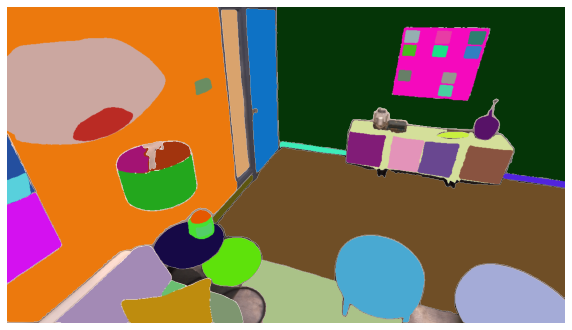

First iter unique 33


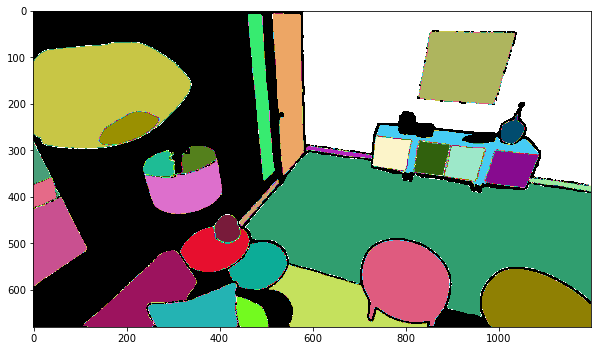

The Found Projection instance 1
Mapping {-100: -100, 0: 0, 1: 32, 2: 0, 3: 0, 4: 0, 6: 0, 10: 0, 12: 0, 14: 0, 17: 0, 18: 0, 20: 0, 21: 0, 23: 0, 26: 0, 28: 0, 29: 0, 30: 2, 31: 0}
MaxId 32


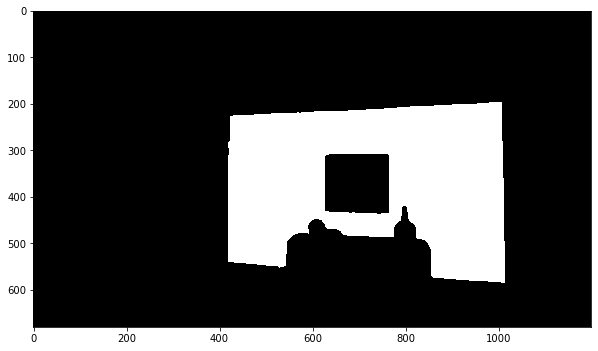

CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Projection instance 0
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 6: 0, 10: 0, 12: 0, 14: 0, 17: 0, 18: 0, 20: 0, 21: 0, 23: 0, 26: 0, 28: 0, 29: 0, 30: 0, 31: 0}
MaxId 33


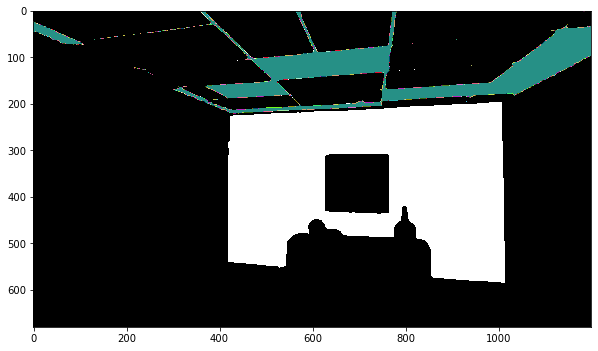

The Found Projection instance 0
Mapping {-100: -100, 0: 13, 1: 0, 2: 0, 3: 0, 4: 0, 6: 0, 10: 0, 12: 0, 14: 0, 17: 0, 18: 1, 20: 0, 21: 0, 23: 0, 26: 0, 28: 0, 29: 0, 30: 0, 31: 0}
MaxId 33


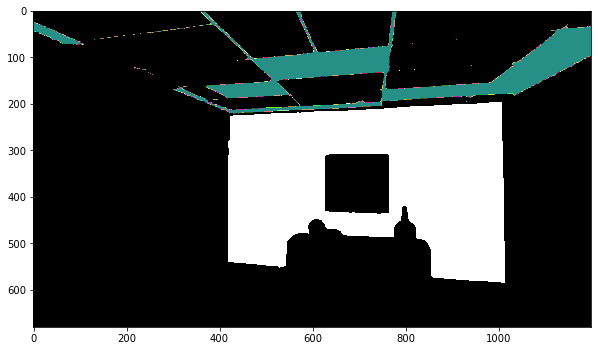

CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Projection instance 0
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 6: 0, 10: 0, 12: 0, 14: 0, 17: 0, 18: 0, 20: 0, 21: 0, 23: 0, 26: 0, 28: 0, 29: 0, 30: 0, 31: 0}
MaxId 34


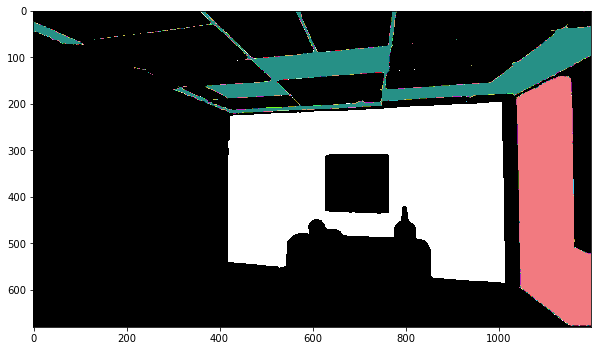

The Found Projection instance 2
Mapping {-100: -100, 0: 0, 1: 0, 2: 5, 3: 0, 4: 0, 6: 0, 10: 0, 12: 0, 14: 0, 17: 0, 18: 0, 20: 0, 21: 0, 23: 0, 26: 0, 28: 0, 29: 0, 30: 0, 31: 0}
MaxId 34


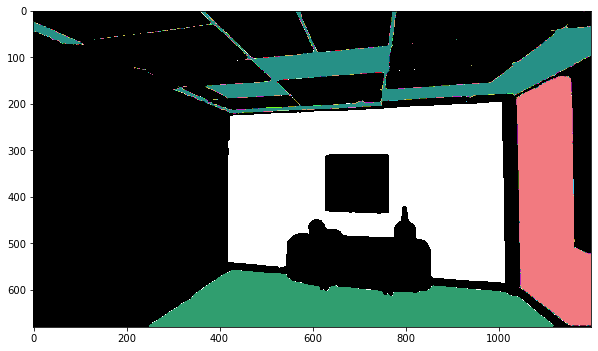

The Found Projection instance 4
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 3: 0, 4: 14, 6: 0, 10: 0, 12: 0, 14: 0, 17: 0, 18: 0, 20: 2, 21: 1, 23: 1, 26: 0, 28: 0, 29: 0, 30: 0, 31: 0}
MaxId 34


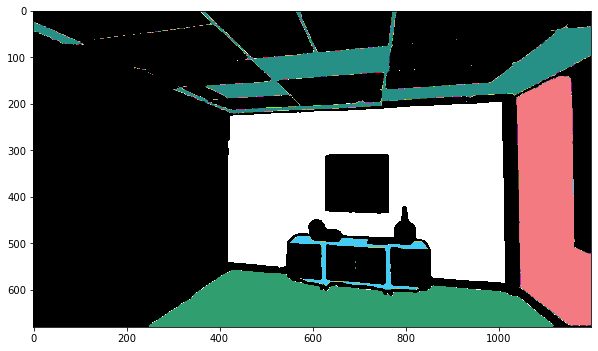

The Found Projection instance 10
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 6: 0, 10: 21, 12: 0, 14: 0, 17: 0, 18: 0, 20: 0, 21: 0, 23: 0, 26: 0, 28: 0, 29: 0, 30: 0, 31: 0}
MaxId 34


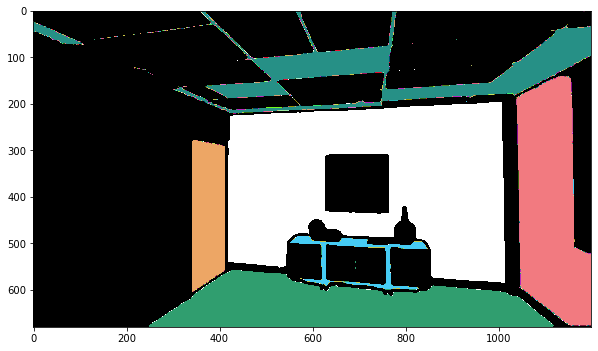

CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Projection instance 0
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 6: 0, 10: 0, 12: 0, 14: 0, 17: 0, 18: 0, 20: 0, 21: 0, 23: 0, 26: 0, 28: 0, 29: 0, 30: 0, 31: 0}
MaxId 35


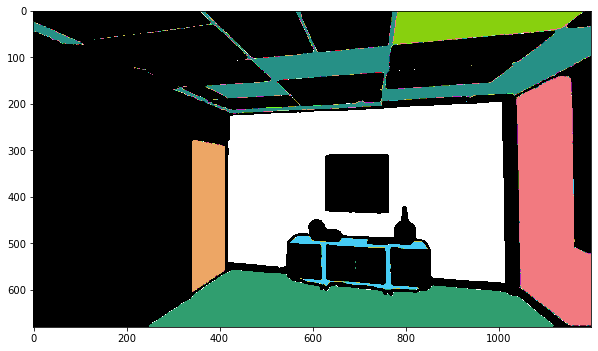

CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Projection instance 0
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 6: 0, 10: 0, 12: 0, 14: 0, 17: 0, 18: 0, 20: 0, 21: 0, 23: 0, 26: 0, 28: 0, 29: 0, 30: 0, 31: 0}
MaxId 36


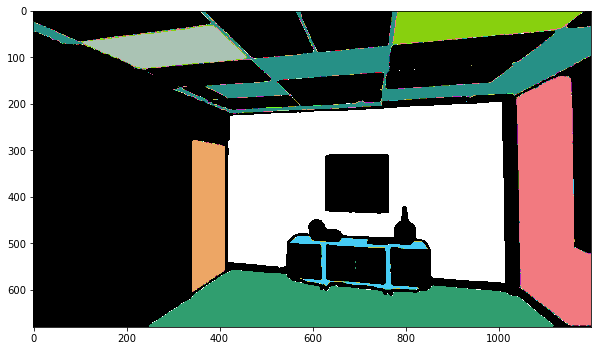

CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Projection instance 0
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 6: 0, 10: 0, 12: 0, 14: 0, 17: 0, 18: 0, 20: 0, 21: 0, 23: 0, 26: 0, 28: 0, 29: 0, 30: 0, 31: 0}
MaxId 37


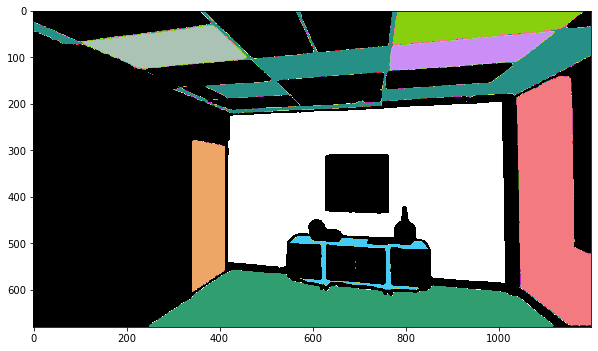

CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Projection instance 0
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 6: 0, 10: 0, 12: 0, 14: 0, 17: 0, 18: 0, 20: 0, 21: 0, 23: 0, 26: 0, 28: 0, 29: 0, 30: 0, 31: 0}
MaxId 38


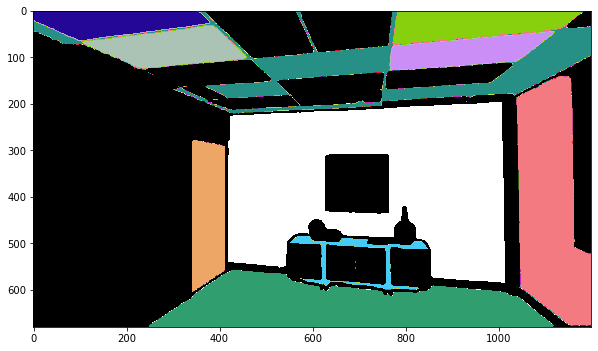

CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Projection instance 0
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 6: 0, 10: 0, 12: 0, 14: 0, 17: 0, 18: 0, 20: 0, 21: 0, 23: 0, 26: 0, 28: 0, 29: 0, 30: 0, 31: 0}
MaxId 39


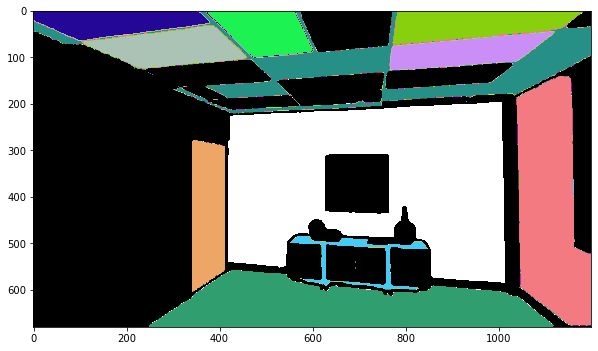

The Found Projection instance 6
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 6: 27, 10: 0, 12: 0, 14: 0, 17: 0, 18: 0, 20: 0, 21: 0, 23: 0, 26: 0, 28: 0, 29: 0, 30: 0, 31: 0}
MaxId 39


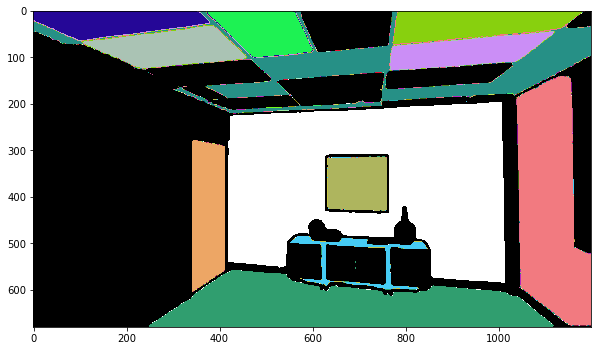

CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Projection instance 0
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 6: 0, 10: 0, 12: 0, 14: 0, 17: 0, 18: 0, 20: 0, 21: 0, 23: 0, 26: 0, 28: 0, 29: 0, 30: 0, 31: 0}
MaxId 40


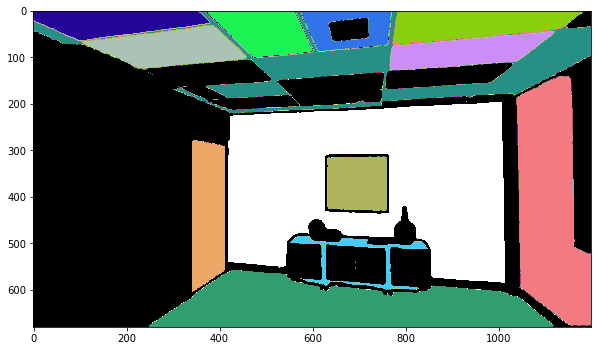

CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Projection instance 0
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 6: 0, 10: 0, 12: 0, 14: 0, 17: 0, 18: 0, 20: 0, 21: 0, 23: 0, 26: 0, 28: 0, 29: 0, 30: 0, 31: 0}
MaxId 41


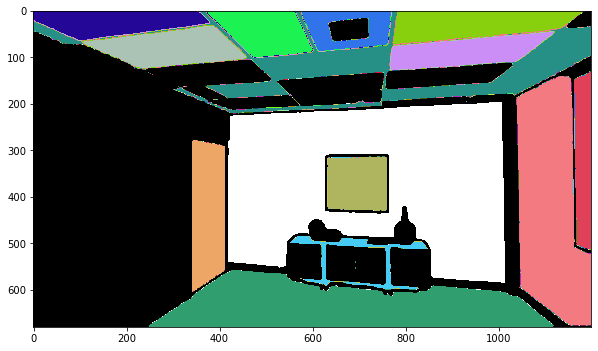

CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Projection instance 0
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 6: 0, 10: 0, 12: 0, 14: 0, 17: 0, 18: 0, 20: 0, 21: 0, 23: 0, 26: 0, 28: 0, 29: 0, 30: 0, 31: 0}
MaxId 42


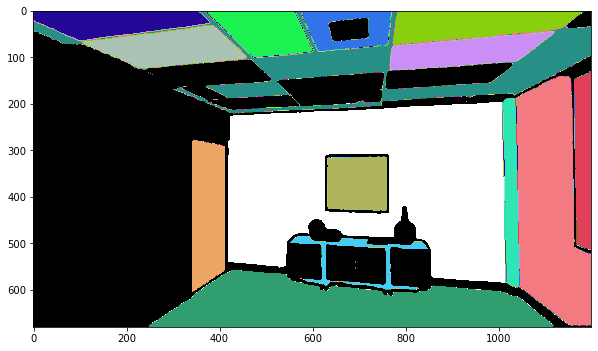

The Found Projection instance 3
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 3: 6, 4: 0, 6: 0, 10: 0, 12: 0, 14: 0, 17: 0, 18: 0, 20: 0, 21: 0, 23: 0, 26: 0, 28: 0, 29: 0, 30: 0, 31: 0}
MaxId 42


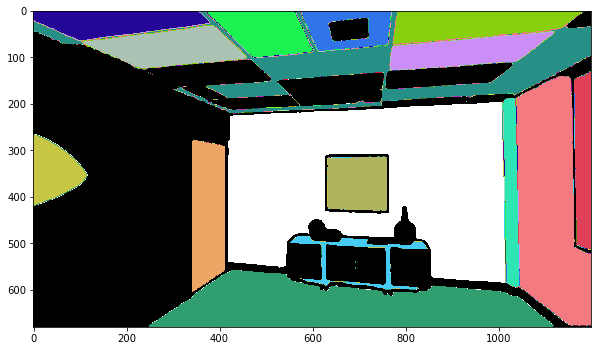

CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Projection instance 0
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 6: 0, 10: 0, 12: 0, 14: 0, 17: 0, 18: 0, 20: 0, 21: 0, 23: 0, 26: 0, 28: 0, 29: 0, 30: 0, 31: 0}
MaxId 43


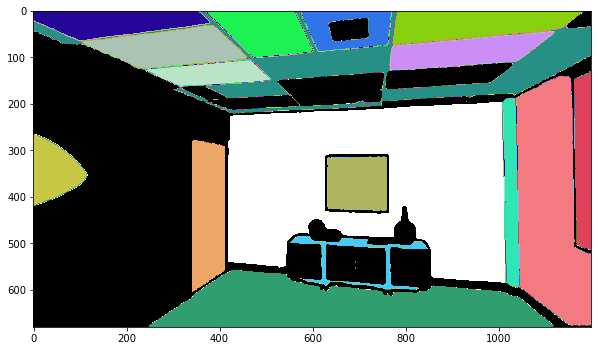

CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Projection instance 0
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 6: 0, 10: 0, 12: 0, 14: 0, 17: 0, 18: 0, 20: 0, 21: 0, 23: 0, 26: 0, 28: 0, 29: 0, 30: 0, 31: 0}
MaxId 44


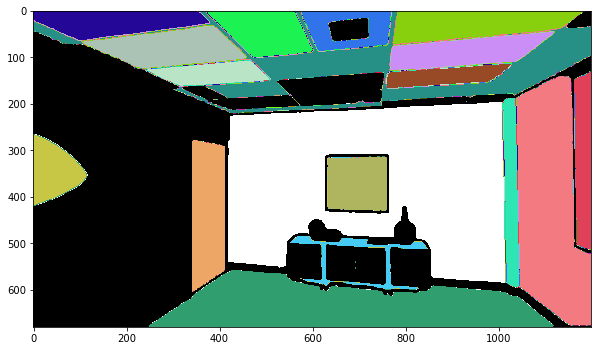

The Found Projection instance 12
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 6: 0, 10: 0, 12: 7, 14: 0, 17: 0, 18: 0, 20: 0, 21: 0, 23: 0, 26: 0, 28: 0, 29: 0, 30: 0, 31: 0}
MaxId 44


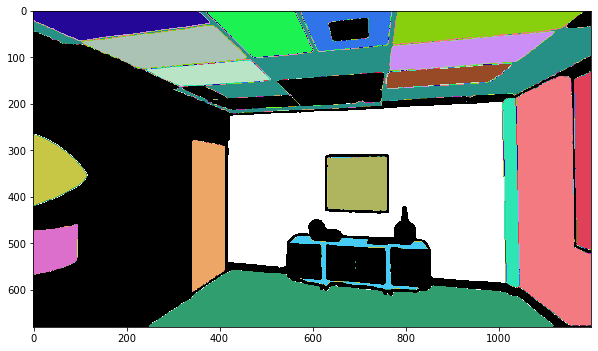

CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Projection instance 0
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 6: 0, 10: 0, 12: 0, 14: 0, 17: 0, 18: 0, 20: 0, 21: 0, 23: 0, 26: 0, 28: 0, 29: 0, 30: 0, 31: 0}
MaxId 45


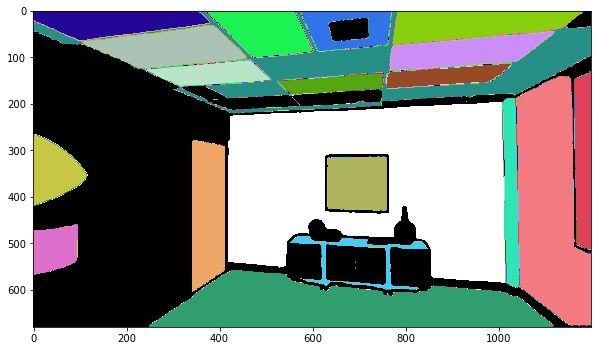

The Found Projection instance 17
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 3: 0, 4: 2, 6: 0, 10: 0, 12: 0, 14: 0, 17: 25, 18: 0, 20: 0, 21: 0, 23: 0, 26: 0, 28: 0, 29: 0, 30: 0, 31: 0}
MaxId 45


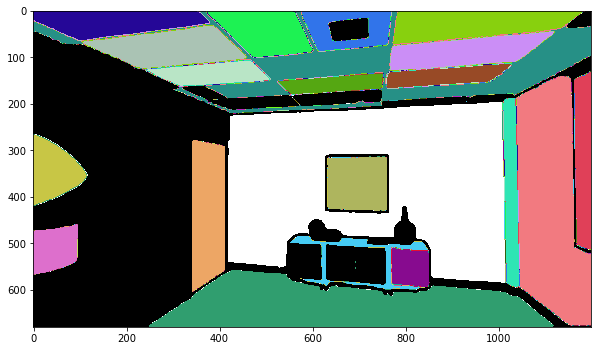

The Found Projection instance 21
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 6: 0, 10: 0, 12: 0, 14: 0, 17: 0, 18: 0, 20: 0, 21: 23, 23: 0, 26: 0, 28: 0, 29: 0, 30: 0, 31: 0}
MaxId 45


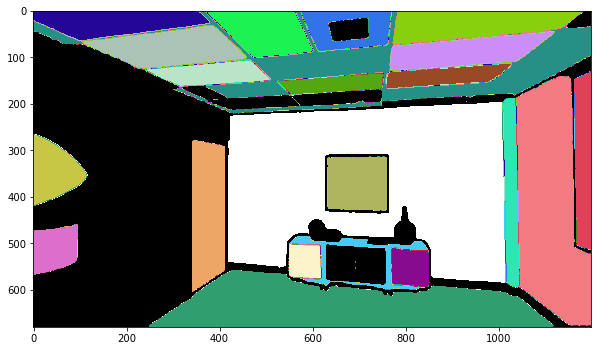

The Found Projection instance 20
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 6: 0, 10: 0, 12: 0, 14: 0, 17: 0, 18: 0, 20: 22, 21: 0, 23: 0, 26: 0, 28: 0, 29: 0, 30: 0, 31: 0}
MaxId 45


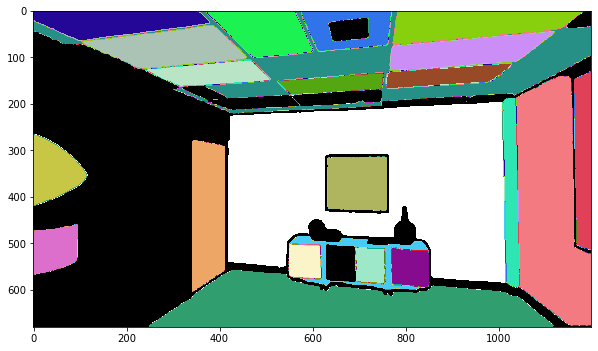

The Found Projection instance 23
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 6: 0, 10: 0, 12: 0, 14: 0, 17: 0, 18: 0, 20: 0, 21: 0, 23: 23, 26: 0, 28: 0, 29: 0, 30: 0, 31: 0}
MaxId 45


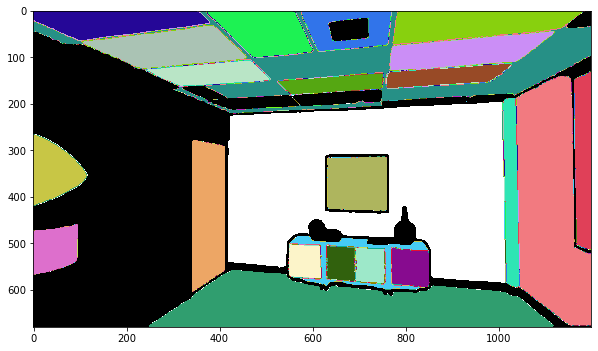

The Found Projection instance 29
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 6: 0, 10: 0, 12: 0, 14: 0, 17: 0, 18: 0, 20: 0, 21: 0, 23: 0, 26: 0, 28: 0, 29: 21, 30: 0, 31: 0}
MaxId 45


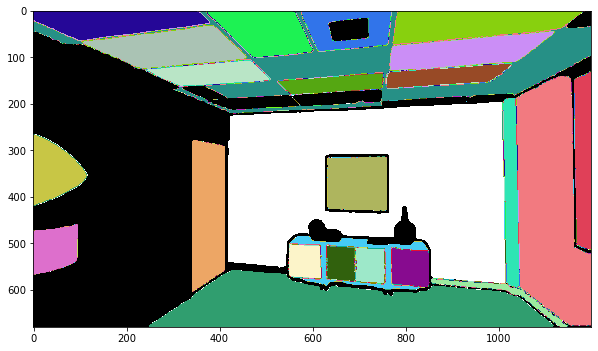

CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Projection instance 0
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 6: 0, 10: 0, 12: 0, 14: 0, 17: 0, 18: 0, 20: 0, 21: 0, 23: 0, 26: 0, 28: 0, 29: 0, 30: 0, 31: 0}
MaxId 46


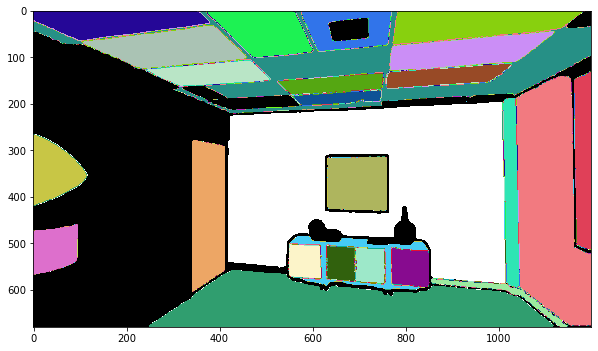

The Found Projection instance 26
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 6: 0, 10: 0, 12: 0, 14: 0, 17: 0, 18: 0, 20: 0, 21: 0, 23: 0, 26: 12, 28: 0, 29: 0, 30: 0, 31: 0}
MaxId 46


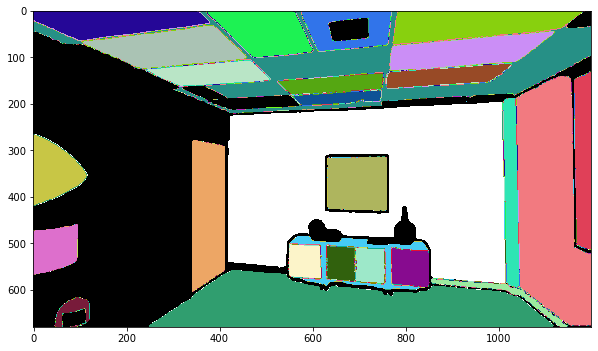

CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Projection instance 0
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 6: 0, 10: 0, 12: 0, 14: 0, 17: 0, 18: 0, 20: 0, 21: 0, 23: 0, 26: 0, 28: 0, 29: 0, 30: 0, 31: 0}
MaxId 47


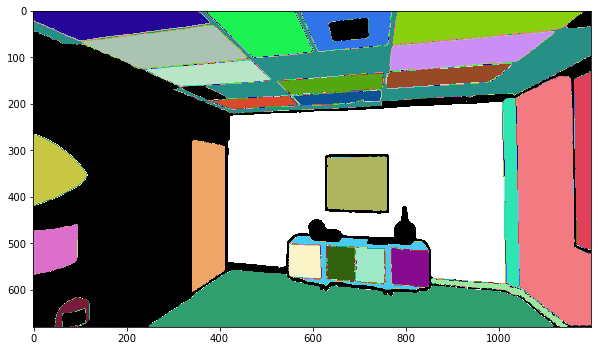

CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Projection instance 0
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 6: 0, 10: 0, 12: 0, 14: 0, 17: 0, 18: 0, 20: 0, 21: 0, 23: 0, 26: 0, 28: 0, 29: 0, 30: 0, 31: 0}
MaxId 48


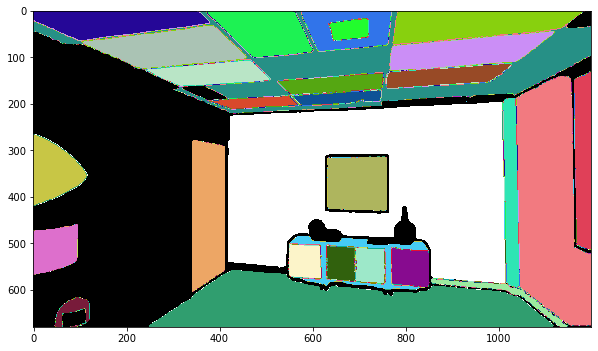

CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Projection instance 0
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 6: 0, 10: 0, 12: 0, 14: 0, 17: 0, 18: 0, 20: 0, 21: 0, 23: 0, 26: 0, 28: 0, 29: 0, 30: 0, 31: 0}
MaxId 49


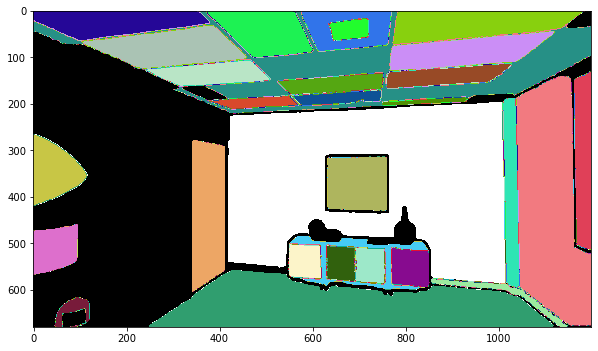

The Found Projection instance 31
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 6: 0, 10: 0, 12: 0, 14: 0, 17: 0, 18: 0, 20: 0, 21: 0, 23: 0, 26: 0, 28: 0, 29: 0, 30: 0, 31: 7}
MaxId 49


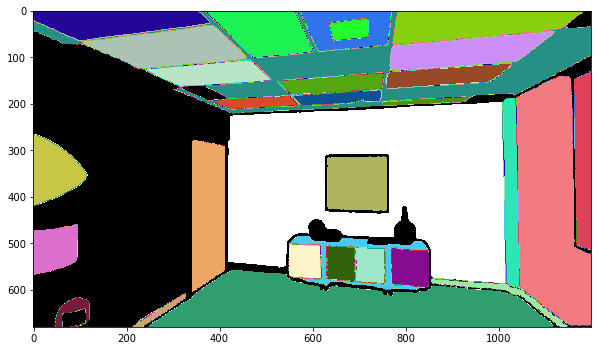

The Found Projection instance 28
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 6: 0, 10: 0, 12: 0, 14: 0, 17: 0, 18: 0, 20: 0, 21: 0, 23: 0, 26: 0, 28: 19, 29: 0, 30: 0, 31: 0}
MaxId 49


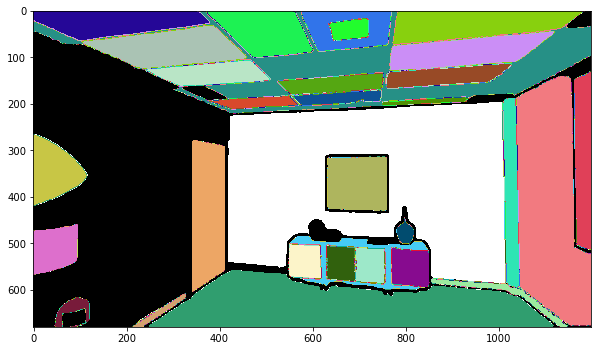

CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Projection instance 0
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 6: 0, 10: 0, 12: 0, 14: 0, 17: 0, 18: 0, 20: 0, 21: 0, 23: 0, 26: 0, 28: 0, 29: 0, 30: 0, 31: 0}
MaxId 50


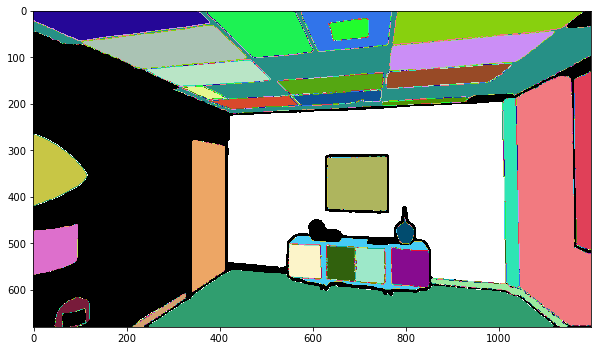

The Found Projection instance 26
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 6: 0, 10: 0, 12: 0, 14: 0, 17: 0, 18: 0, 20: 0, 21: 0, 23: 0, 26: 2, 28: 0, 29: 0, 30: 0, 31: 0}
MaxId 50


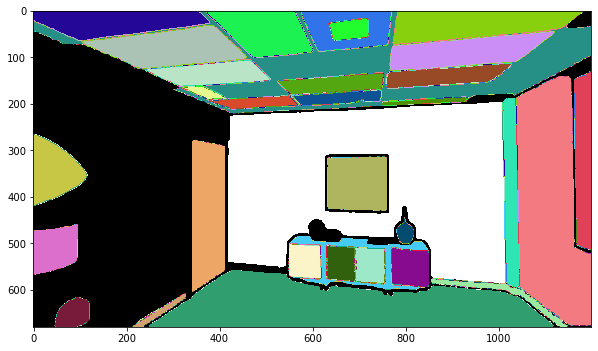

CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Projection instance 0
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 6: 0, 10: 0, 12: 0, 14: 0, 17: 0, 18: 0, 20: 0, 21: 0, 23: 0, 26: 0, 28: 0, 29: 0, 30: 0, 31: 0}
MaxId 51


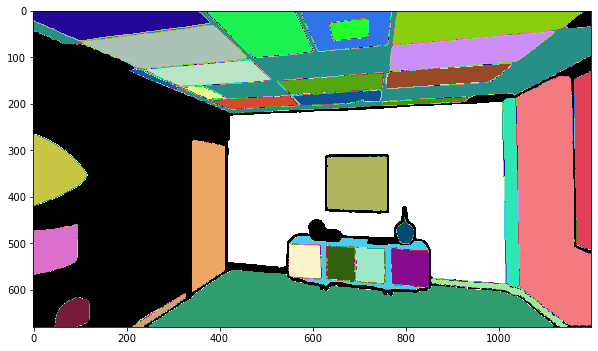

CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Projection instance 0
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 6: 0, 10: 0, 12: 0, 14: 0, 17: 0, 18: 0, 20: 0, 21: 0, 23: 0, 26: 0, 28: 0, 29: 0, 30: 0, 31: 0}
MaxId 52


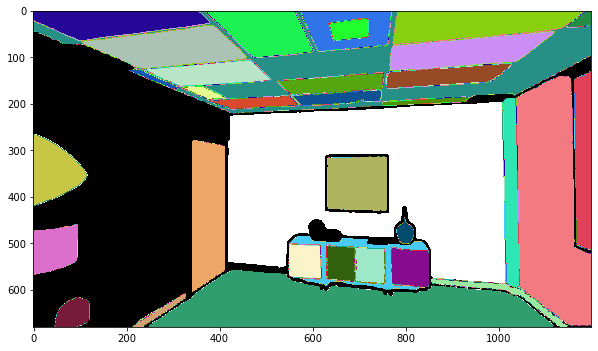

CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Projection instance 0
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 6: 0, 10: 0, 12: 0, 14: 0, 17: 0, 18: 0, 20: 0, 21: 0, 23: 0, 26: 0, 28: 0, 29: 0, 30: 0, 31: 0}
MaxId 53


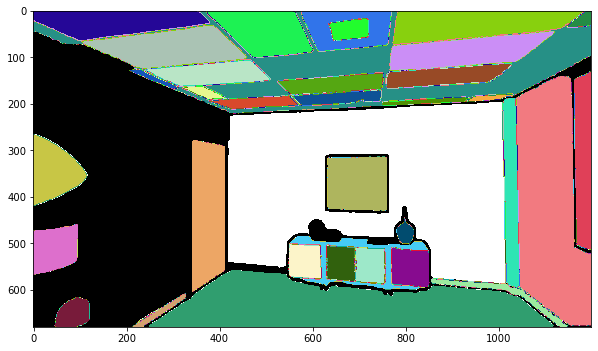

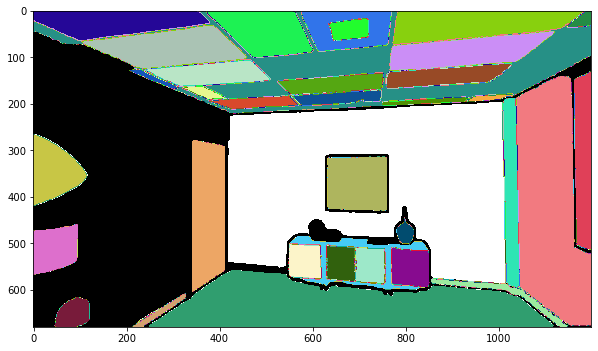

Current unique ids [-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19   20   21   22   23   24   25   26
   27   28   29   30   31   32   33   34   35   36   37]
The Found Projection instance 29
Mapping {-100: -100, 0: 0, 1: 1, 2: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 10: 0, 14: 0, 17: 0, 20: 0, 21: 0, 23: 0, 28: 0, 29: 7, 30: 1, 31: 0, 33: 0, 41: 0}
MaxId 53


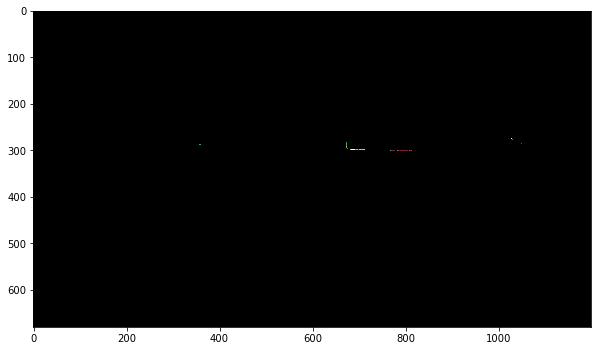

The Found Projection instance 1
Mapping {-100: -100, 0: 0, 1: 50, 2: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 10: 0, 14: 0, 17: 0, 20: 0, 21: 0, 23: 0, 28: 0, 29: 0, 30: 0, 31: 0, 33: 0, 41: 0}
MaxId 53


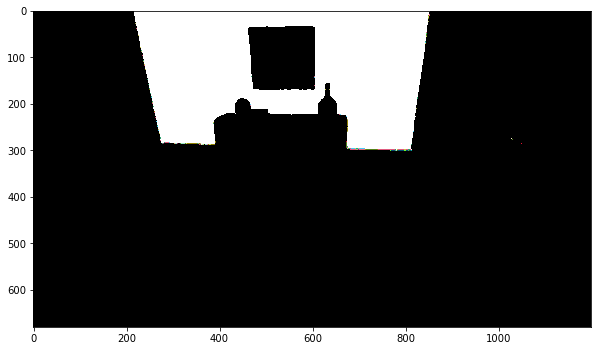

The Found Projection instance 8
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 25, 10: 0, 14: 0, 17: 0, 20: 0, 21: 0, 23: 0, 28: 0, 29: 0, 30: 0, 31: 0, 33: 0, 41: 0}
MaxId 53


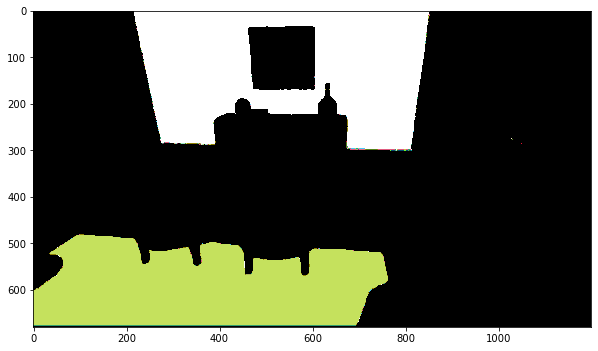

The Found Projection instance 2
Mapping {-100: -100, 0: 0, 1: 0, 2: 32, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 10: 0, 14: 0, 17: 0, 20: 0, 21: 0, 23: 0, 28: 0, 29: 0, 30: 0, 31: 0, 33: 0, 41: 0}
MaxId 53


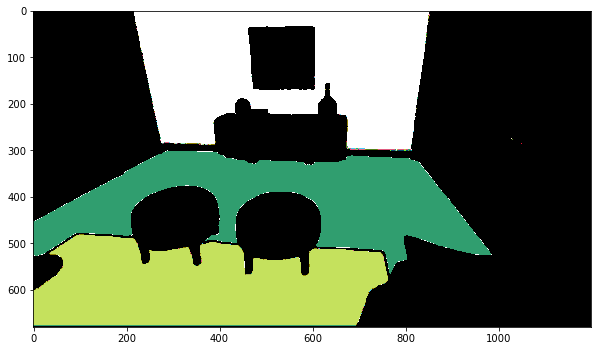

The Found Projection instance 33
Mapping {-100: -100, 0: 0, 1: 1, 2: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 10: 0, 14: 0, 17: 0, 20: 0, 21: 0, 23: 0, 28: 0, 29: 0, 30: 0, 31: 0, 33: 14, 41: 0}
MaxId 53


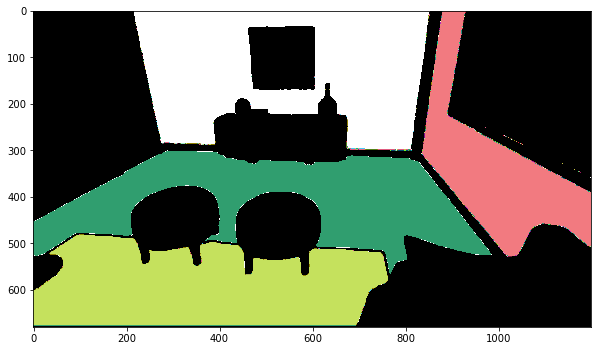

CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Projection instance 0
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 10: 0, 14: 0, 17: 0, 20: 0, 21: 0, 23: 0, 28: 0, 29: 0, 30: 0, 31: 0, 33: 0, 41: 0}
MaxId 54


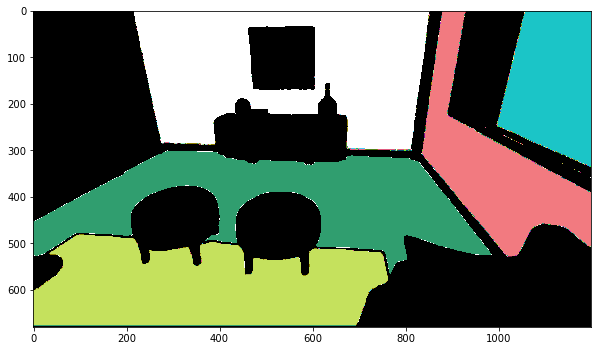

CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Projection instance 0
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 10: 0, 14: 0, 17: 0, 20: 0, 21: 0, 23: 0, 28: 0, 29: 0, 30: 0, 31: 0, 33: 0, 41: 0}
MaxId 55


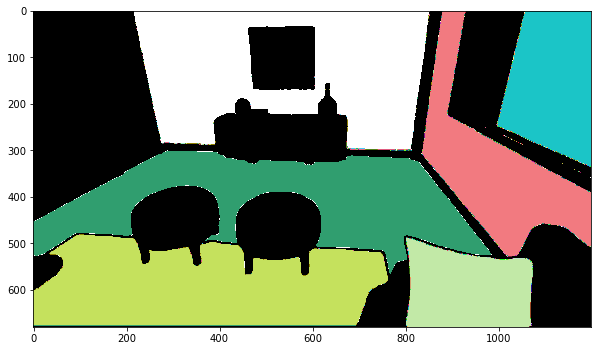

The Found Projection instance 10
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 10: 45, 14: 0, 17: 0, 20: 0, 21: 0, 23: 0, 28: 0, 29: 0, 30: 0, 31: 0, 33: 0, 41: 0}
MaxId 55


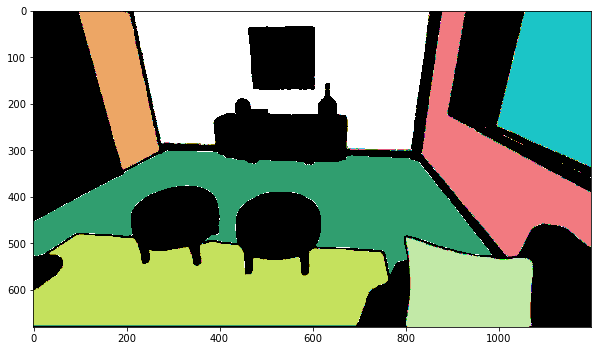

The Found Projection instance 14
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 10: 1, 14: 21, 17: 0, 20: 0, 21: 0, 23: 0, 28: 0, 29: 0, 30: 0, 31: 0, 33: 0, 41: 0}
MaxId 55


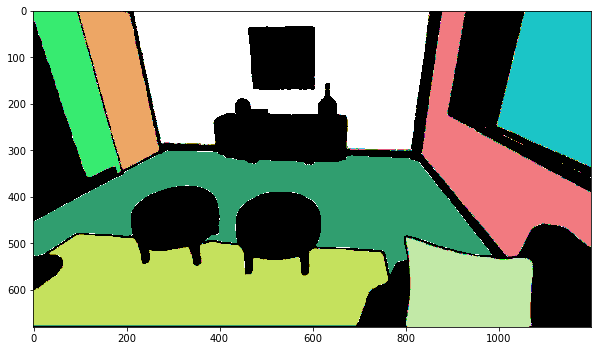

CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Projection instance 0
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 10: 0, 14: 0, 17: 0, 20: 0, 21: 0, 23: 0, 28: 0, 29: 0, 30: 0, 31: 0, 33: 0, 41: 0}
MaxId 56


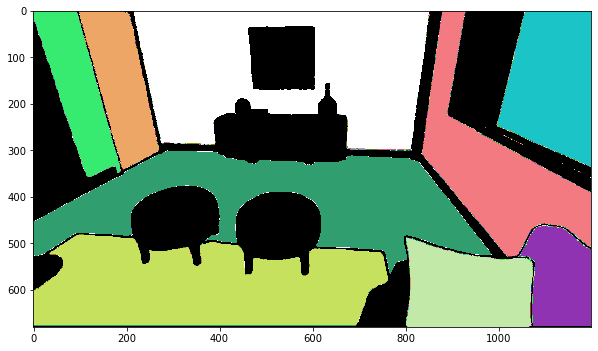

The Found Projection instance 4
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 4: 24, 5: 0, 6: 0, 7: 0, 8: 0, 10: 0, 14: 0, 17: 2, 20: 3, 21: 2, 23: 1, 28: 0, 29: 0, 30: 0, 31: 0, 33: 0, 41: 0}
MaxId 56


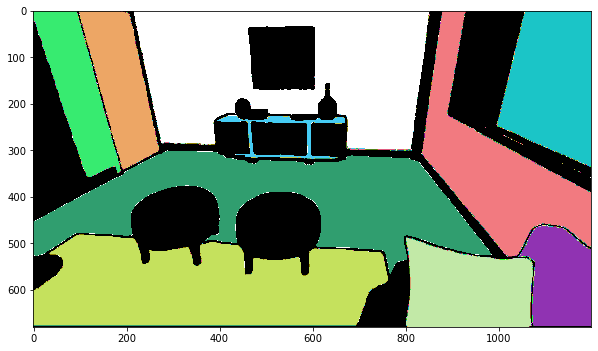

The Found Projection instance 7
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 4: 0, 5: 0, 6: 0, 7: 24, 8: 0, 10: 0, 14: 0, 17: 0, 20: 0, 21: 0, 23: 0, 28: 0, 29: 0, 30: 0, 31: 0, 33: 0, 41: 0}
MaxId 56


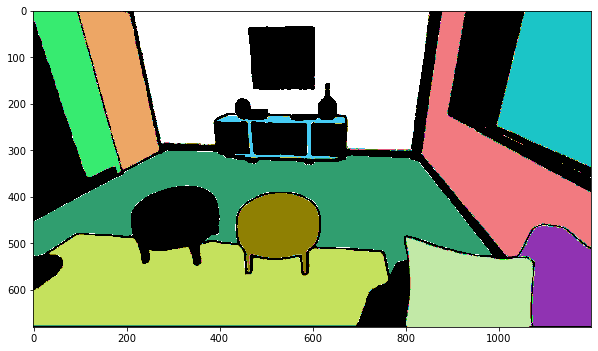

The Found Projection instance 5
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 4: 0, 5: 25, 6: 0, 7: 0, 8: 0, 10: 0, 14: 0, 17: 0, 20: 0, 21: 0, 23: 0, 28: 0, 29: 0, 30: 0, 31: 0, 33: 0, 41: 0}
MaxId 56


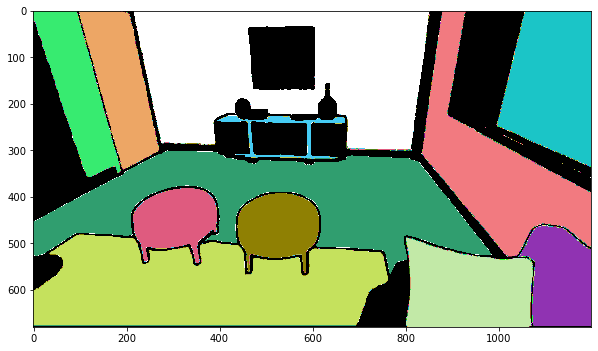

The Found Projection instance 6
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 4: 0, 5: 0, 6: 52, 7: 0, 8: 0, 10: 0, 14: 0, 17: 0, 20: 0, 21: 0, 23: 0, 28: 0, 29: 0, 30: 0, 31: 0, 33: 0, 41: 0}
MaxId 56


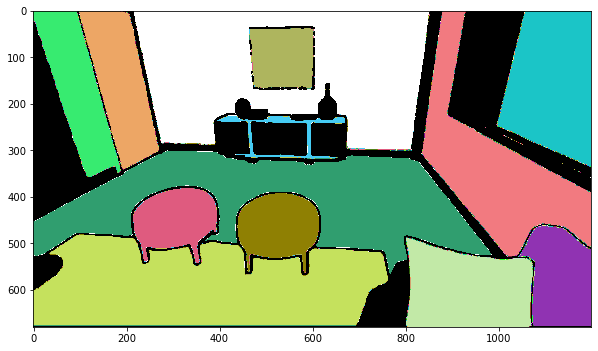

CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Projection instance 0
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 10: 0, 14: 0, 17: 0, 20: 0, 21: 0, 23: 0, 28: 0, 29: 0, 30: 0, 31: 0, 33: 0, 41: 0}
MaxId 57


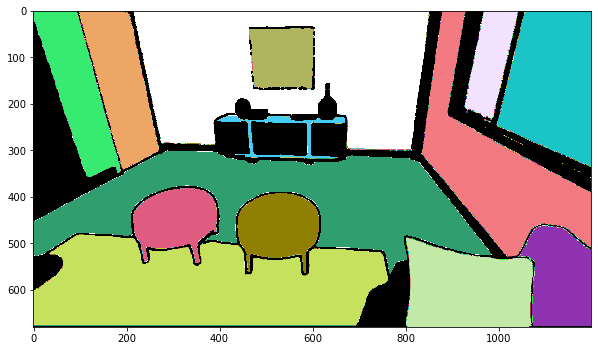

CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Projection instance 0
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 10: 0, 14: 0, 17: 0, 20: 0, 21: 0, 23: 0, 28: 0, 29: 0, 30: 0, 31: 0, 33: 0, 41: 0}
MaxId 58


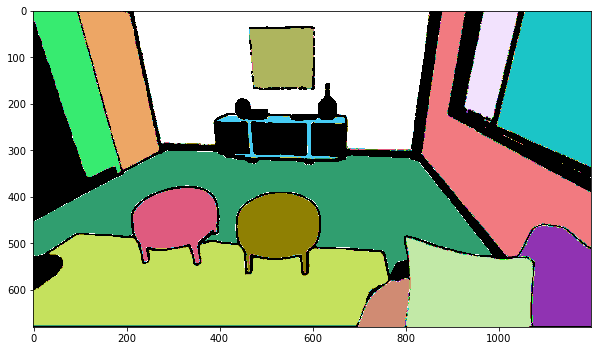

The Found Projection instance 33
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 10: 0, 14: 0, 17: 0, 20: 0, 21: 0, 23: 0, 28: 0, 29: 0, 30: 0, 31: 0, 33: 2, 41: 0}
MaxId 58


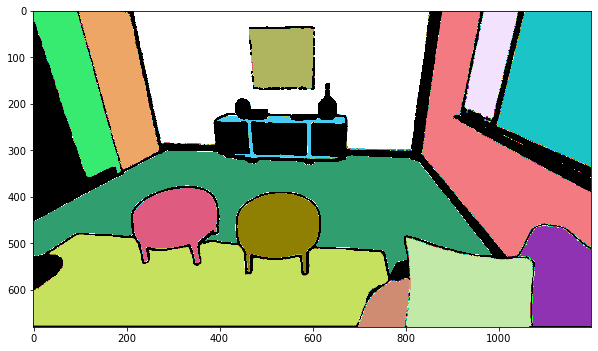

The Found Projection instance 41
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 10: 0, 14: 0, 17: 0, 20: 0, 21: 0, 23: 0, 28: 0, 29: 0, 30: 0, 31: 0, 33: 0, 41: 18}
MaxId 58


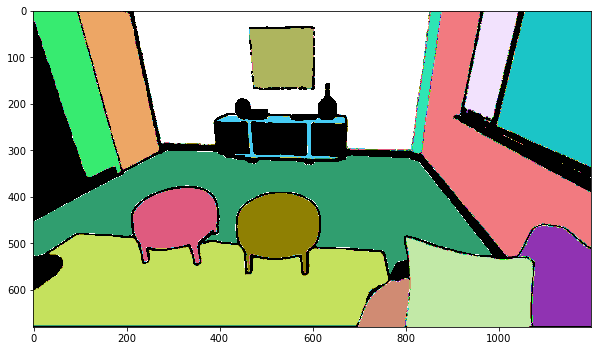

CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Projection instance 0
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 10: 0, 14: 0, 17: 0, 20: 0, 21: 0, 23: 0, 28: 0, 29: 0, 30: 0, 31: 0, 33: 0, 41: 0}
MaxId 59


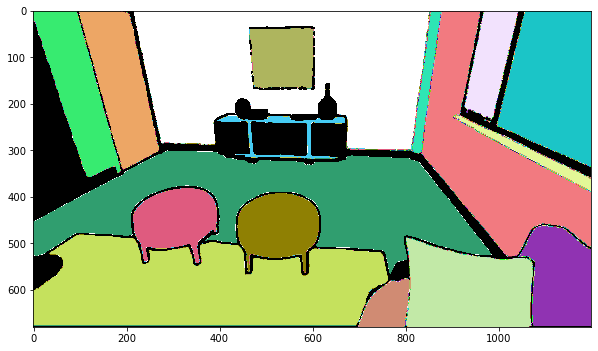

The Found Projection instance 17
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 10: 0, 14: 0, 17: 46, 20: 0, 21: 0, 23: 0, 28: 0, 29: 0, 30: 0, 31: 0, 33: 0, 41: 0}
MaxId 59


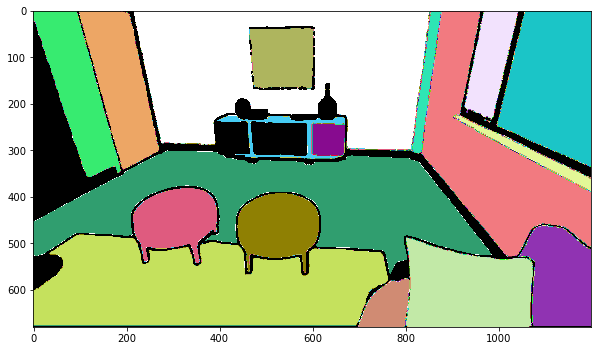

The Found Projection instance 29
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 10: 0, 14: 0, 17: 0, 20: 0, 21: 0, 23: 0, 28: 0, 29: 13, 30: 0, 31: 0, 33: 0, 41: 0}
MaxId 59


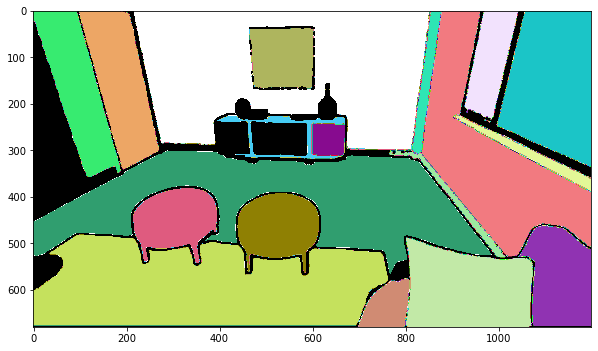

The Found Projection instance 21
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 10: 0, 14: 0, 17: 0, 20: 0, 21: 46, 23: 0, 28: 0, 29: 0, 30: 0, 31: 0, 33: 0, 41: 0}
MaxId 59


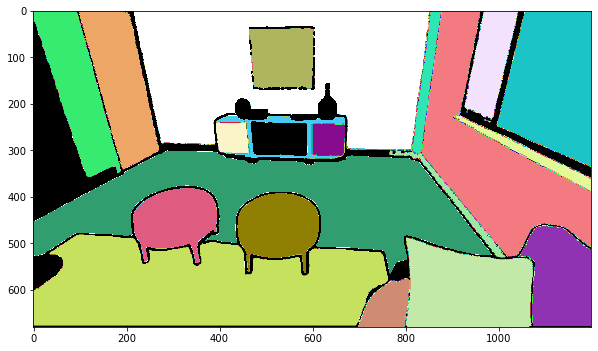

The Found Projection instance 20
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 10: 0, 14: 0, 17: 0, 20: 45, 21: 0, 23: 0, 28: 0, 29: 0, 30: 0, 31: 0, 33: 0, 41: 0}
MaxId 59


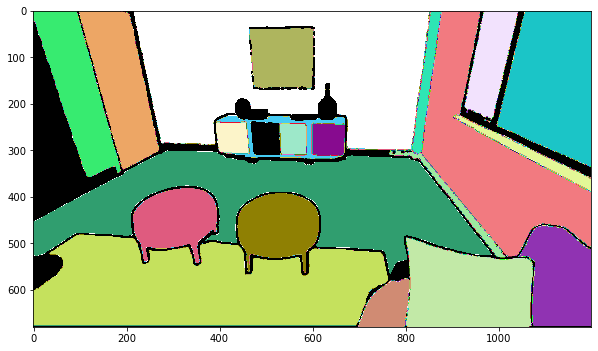

The Found Projection instance 23
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 10: 0, 14: 0, 17: 0, 20: 0, 21: 0, 23: 46, 28: 0, 29: 0, 30: 0, 31: 0, 33: 0, 41: 0}
MaxId 59


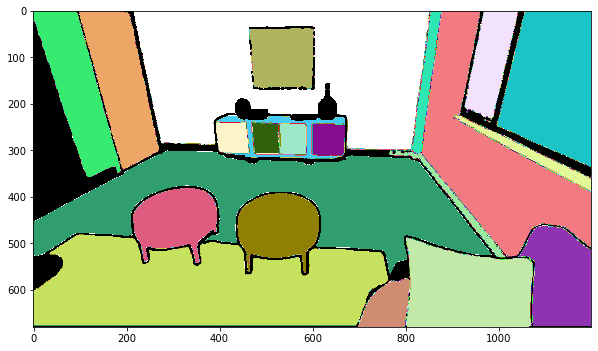

The Found Projection instance 28
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 10: 0, 14: 0, 17: 0, 20: 0, 21: 0, 23: 0, 28: 34, 29: 0, 30: 0, 31: 0, 33: 0, 41: 0}
MaxId 59


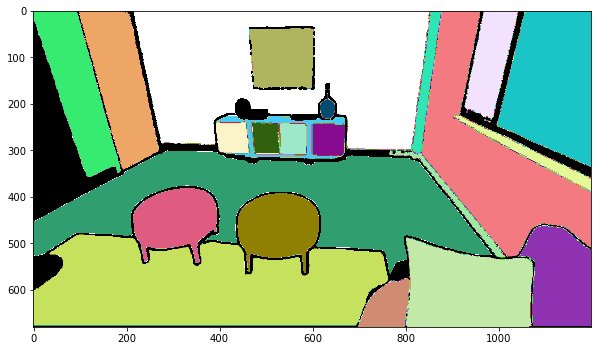

CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN
The Found Projection instance 0
Mapping {-100: -100, 0: 0, 1: 0, 2: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 10: 0, 14: 0, 17: 0, 20: 0, 21: 0, 23: 0, 28: 0, 29: 0, 30: 0, 31: 0, 33: 0, 41: 0}
MaxId 60


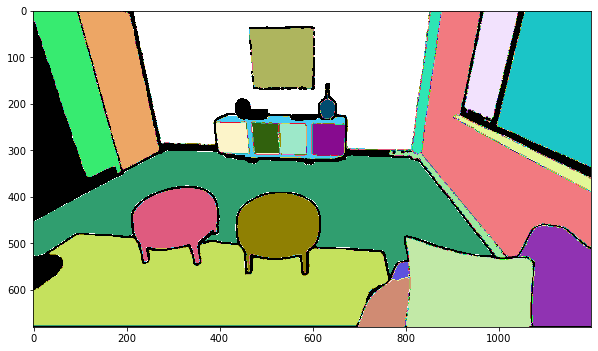

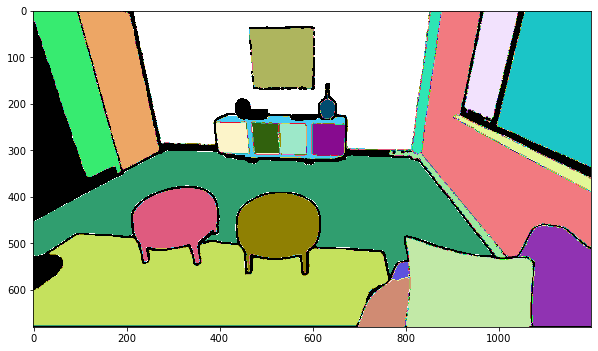

Current unique ids [-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14   15   16   17   18   19   20   21   22   23   24   25]


In [ ]:
# main loop
samples=None
visu=vis.visualizerForIds()
max_id=0
for i in range(0,3):
    currFramenumber=i*100
    color_data = cv2.imread(color_paths[currFramenumber])
    image = cv2.cvtColor(color_data, cv2.COLOR_BGR2RGB)
    masks, samples, max_id=createFrontMappingAutosort(currFramenumber, T_wc, K, depth_paths, mask_generator, max_id=max_id, smallesMaskSize=1000,current_frame=image, samples=samples,verbose=False)
    #print(i)
torch.cuda.empty_cache()